In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import Functions as AC
from scipy.stats import loguniform, uniform
from IPython.display import display, Math
import corner
import random 


## Description of System1 and System2 csv files

### Three parameters: 

$\quad$ -time_d: Time (days)

$\quad$ -rv_ms: Radial velocity (m/s)

$\quad$ -sig_rv_ms: Uncertainty on radial velocity measurements (m/s)

In [2]:
df1 = AC.data_loader('system1.csv')
df2 = AC.data_loader('system2.csv')

In [3]:
time1 = np.array(df1['time_d'])
rv1 = np.array(df1['rv_ms'])
sig1 = np.array(df1['sig_rv_ms'])

time2 = df2['time_d']
rv2 = df2['rv_ms']
sig2 = df2['sig_rv_ms']

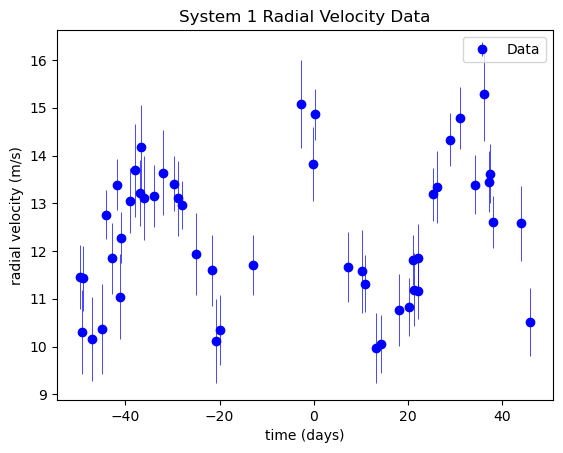

In [4]:
fig = plt.figure()
plt.errorbar(time1, rv1, yerr=sig1, elinewidth=.5, color='blue', marker='o', ls='none', label='Data')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (m/s)')
plt.title('System 1 Radial Velocity Data')
plt.legend()
plt.show()

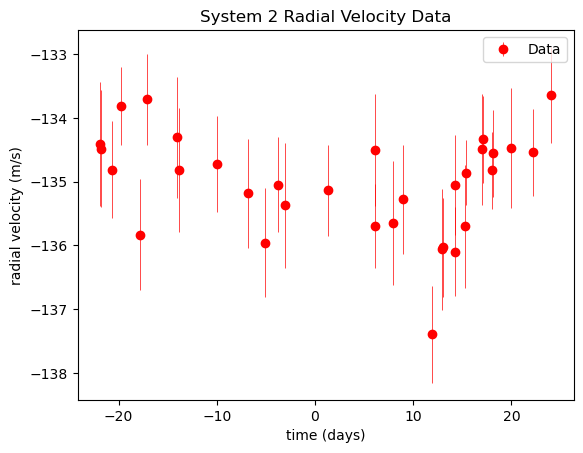

In [5]:
fig = plt.figure()
plt.errorbar(time2, rv2, yerr=sig2, elinewidth=.5, color='red', marker='o', ls='none', label='Data')
plt.xlabel('time (days)')
plt.ylabel('radial velocity (m/s)')
plt.title('System 2 Radial Velocity Data')
plt.legend()
plt.show()

# The Forward Model

### Deriving the loglikelihood

Given a planet of mass m orbiting a star of mass M, with semi-major axis a, and eccentricity 0, the equation for the measured radial velocity of the system is:

$V(t) = V_0+K\cos(nt+\lambda_0)\;\;\;\;(1)\;\;$ where $\;\;K=\frac{m}{m+M}\frac{2\pi a\sin i}{P}\;\;$ is the radial velocity semi amplitude

The parameters of concern in this situation are $\theta=(V_0, K, \lambda_0)$

We can find an expression for the loglikelihood function:

Since we know that these measurements are affected by $\textbf{Uncorrelated Gaussian White Noise}$ we can compute the probability of the observation $v_k$ give $\theta$ as:

$p(v_k|\theta)=\frac{1}{\sigma_k\sqrt{2\pi}}exp[-\frac{(v_k-V(t_k;\theta))^2}{2\sigma_k^2}]\;\;\;\;(2)\;\;$

Since the GWN is uncorrelated this means that for each $v_k\;(1,...,k)$ given $\theta$ are independent so to get the total likelihood we simply multiply all probabilities together giving:

$\mathcal{L}=\prod_{k=1}^{N}[\frac{1}{\sigma_k\sqrt{2\pi}}exp[-\frac{(v_k-V(t_k))^2}{2\sigma_k^2}]]\;\;\;\;(3)\;\;$

$\because$ products are annoying to work with we can use properties of logs to get the loglikelihood as a summation as opposed to a product. Taking the natural log of both sides:

$ln\mathcal{L}=-\frac{1}{2}\sum_{k=1}^{N}[\frac{(v_k-V(t_k))^2}{\sigma_k^2}+ln(2\pi\sigma_k^2)]\;\;\;\;(4)\;\;$ Note $\;\;ln(2\pi\sigma_k^2)\;\;$ Doesn't depend on $\theta$


### Linearize V(t)

To start were given equation 1 for our formula for the radial velocity. We're then told that we can express that equation as:

$V(t)=A\cos(nt)+B\sin(nt)+C\;\;\;\;(5)\;\;$ where A, B, and C are constants

This linearization is advantageous to the original formula as it is linear as a function of t, meaning that it'll be easier to work with (i.e. fitting the function)

whereas the former has dependence on elements of $\theta$ that make it difficult to fit.

### Deriving A, B, and C

Lets now derive A, B, and C's dependence on the oribital/physical parameters

First note the trig identity: $\cos(\alpha+\beta)=\cos(\alpha)\cos(\beta)-\sin(\alpha)\sin(\beta)\;\;\;\;(6)\;\;$

Noticing that we can assign $\alpha=nt$ and $\beta=\lambda_0$ we get the following formulation of $V(t)$:

$V(t)=V_0+K(\cos(nt)\cos(\lambda_0)-\sin(nt)\sin(\lambda_0))\;\;\;\;(7)\;\;$

Organizing terms together as $\;\;V(t)=K\cos(\lambda_0)\cos(nt)-K\sin(\lambda_0)\sin(nt)+V_0\;\;\;\;(8)\;\;$ 

Notice how equation 8 matches the form of equation 5 with:

$\quad$ $\cdot\;A=K\cos(\lambda_0)$

$\quad$ $\cdot\;B=-K\sin(\lambda_0)$

$\quad$ $\cdot\;C=V_0$

# Calculating the Maximum Likelihood Estimator (MLE)

The MLE is defined as $\hat{\theta}=argmax_\theta\;\mathcal{L}_k(\theta;t)\;\;\;$ or in other words the values of theta that maximize the likelihood

We can express this minimizing $\;[ln(\sigma_k^2)+\frac{(v_k-V(t_k))^2}{\sigma_k^2}]=\sum_{k=1}^{N}\frac{(v_k-Ac_k-Bs_k-C)^2}{\sigma_k^2}\;\;\;$ where $\;\vec{c_k}\equiv\cos(nt_k)\;$ and $\;\vec{s_k}\equiv\sin(nt_k)$

And since the uncertainties are assumed from a normal distrubtuon we can use weighted least squares to maximize $\mathcal{L}$ and find $\hat{\theta}=(\hat{A}\;\hat{B}\;\hat{C})^T$

$\vec{v_k}=\vec{X}\theta+\epsilon\;\;\;$ where $\;\;\vec{v_k}=(v_1.....v_N)^T\;\;$ and $\;\;X=(\vec{c_k}\;\vec{s_k}\;\vec{1})$

$\vec{X}^T\vec{W}\vec{X}\hat{\theta}=\vec{X}^T\vec{W}\vec{v_k}\Rightarrow\hat{\theta}=(\vec{X}^T\vec{W}\vec{X})^{-1}\vec{X}^T\vec{W}\vec{v_k}$

Where $\vec{W}$ is a matrix with $\frac{1}{\sigma_k^2}$ on the diagonals


In [6]:
# time, rv, and uncertainty for k times
tk=time1 # (days)
vk=rv1 # (m/s)
sigk=np.array(sig1)

# Period and mean-motion
P = 33 # (days)
n=2*np.pi / P

# Columns of X
ck = np.cos(n*tk) 
sk = np.sin(n*tk)
ones = np.ones(len(tk))

# Make X and transpose of X
X = np.vstack((ck, sk, ones)).T
X_T= X.T

# Weighted diagonal matrix
W = np.diag(1 / sigk**2)

In [7]:
# Calculate maximum likelihood estimator for system 1 data
mle=np.linalg.inv(X_T@W@X)@X_T@W@rv1
print(mle)

# MLE parameters
A=mle[0]
B=mle[1]
C=mle[2]

[ 1.73312835 -0.39934569 12.35107417]


Now lets convert from A, B, and C to our orbital/physical parameters $(K, \lambda_0, V_0)$

Remember:

$\cdot\;A=K\cos(\lambda_0)$

$\cdot\;B=-K\sin(\lambda_0)$

$\cdot\;C=V_0$

To get K in terms of A and B, we take the square of A and B and add them together getting $A^2+B^2=K^2(\cos^2(\lambda_0)+\sin^2(\lambda_0))=K^2$

$\therefore\; K=\sqrt{A^2+B^2}$

Now to get $\lambda_0$ in terms of A and B, we can divide B by A giving $\frac{B}{A}=-\frac{K\sin(\lambda_0)}{K\cos(\lambda_0)}=-\tan(\lambda_0)$

$\therefore\; \lambda_0=\arctan(\frac{-B}{A})$

And of course $V_0=C$, so our job is done there

In [8]:
K = np.sqrt(A**2+B**2)
lamb0=np.arctan(-B/A)
V0=C

display(Math(r'\text{The maximum likelihood estimate of } K, \lambda_0, \text{ and } V_0 \text{ are } K=' + str(K) +r'\text{, }'+ r'\lambda_0=' + str(lamb0)+r'\text{, }' +r'V_0=' + str(V0)))





<IPython.core.display.Math object>

# Metropolis-Hastings

### Bayes Theorem Review:

#### $p(\theta|y)=\frac{p(y|\theta)p(\theta)}{p(y)}\;\; ; \;\; p(y)=\int_{\theta\in\Theta}p(y|\theta)p(\theta)d\theta$

We then define the log prior and log likelihood functions which will come in handy when we construct the Metropolis Hastings algorithm

In [9]:
def logprior(theta):
    P, K, lamb0, V0 = theta

    logp = 0.0

    logp += loguniform.logpdf(P, 1.0, 1000.0) # days
    logp += loguniform.logpdf(K, 0.01, 100.0) # m/s
    logp += uniform.logpdf(lamb0, loc=0.0, scale=2*np.pi)
    logp += uniform.logpdf(V0, loc=-1e4, scale=2e4) # m/s

    return logp

def model(theta, t):
    P, K, lamb0, V0 = theta
    return V0 + K*np.cos((2*np.pi/P*t + lamb0))

def loglike(theta, t, v, sigma):
    model_v = model(theta, t)         
    residual   = v - model_v             
    return -0.5 * np.sum((residual / sigma)**2 + np.log(2*np.pi*sigma**2))

### To generate our proposal we add a random value onto our theta that is dependent on the gaussian function for the variables of interest

### The proposal function looks like: $g(P-P',\sigma_P)g(K-K', \sigma_K)g(\lambda_0-\lambda_0',\sigma_{\lambda_0})g(V_0-V_0',\sigma_{V_0})$ 

### Where $g(x,\sigma)=\frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{x^2}{2\sigma^2}}$

In [10]:
def generate_proposal(theta, sigmas):

    theta = np.asarray(theta)
    sigmas = np.asarray(sigmas)

    step = np.random.normal(loc=0.0, scale=sigmas, size=theta.shape)
    return theta + step

theta_start = [33, K, lamb0, V0]
sigma_start = [0.02, 0.02, 0.01, 1.0]
theta_prop = generate_proposal(theta_start, sigma_start)
print(theta_start)
print(theta_prop)

[33, np.float64(1.778541775288376), np.float64(0.22646629702485993), np.float64(12.351074172134894)]
[33.02665824  1.78643827  0.21045566 11.99258939]


### Now we can feed our intial parameters and uncertainties into a function that will

1) Create the chain

2) Calculate the initial log prior, log likelihood, and log posterior

3) Generate proposed theta

4) Calculate a proposed log prior, log likelihood, and log posterior

5) Calculate the ratio and compare to the log random number

    $\quad$ a) if ratio > log random, accept the proposed parameters

    $\quad$ b) if ratio < log random, reject the proposed parameters and add the old ones to the chain

6) Repeat for whatever number of steps

In [11]:
def mh_sampler(theta_start, sigma_start, nsamples, t, v, sig):
    theta0 = np.asarray(theta_start, dtype=float)
    sigma0 = np.asarray(sigma_start, dtype=float)  
    length = len(theta0)

    # Where we will store indices of our Markov Chain
    chain = np.zeros((nsamples, length))
    chain[0] = theta0 # Set first link in the chain as the initial theta

    
    lnprior0 = logprior(theta0) # Calculate initial prior from proposed theta
    
    if not np.isfinite(lnprior0): # Handles priors outside range
        raise ValueError("Starting theta has -inf prior; choose a different starting point.")

    
    # Calculate the loglike and posterior for the initial proposal
    lnlike0 = loglike(theta0, t, v, sig)
    lnpost0 = lnprior0 + lnlike0

    # Sets proposal and acceptance counters
    n_accepted = 0
    n_proposed = 1 

    
    while n_proposed < nsamples:
        # Generate parameter proposal and calculate prior
        theta1 = generate_proposal(theta0, sigma0)
        lnprior1 = logprior(theta1)

        
        if not np.isfinite(lnprior1): # Checks if proposed prior is infinite
            chain[n_proposed] = theta0
            n_proposed += 1
            continue
        
        # Calculate likelihood and posterior of proposed theta
        lnlike1 = loglike(theta1, t, v, sig)
        lnpost1 = lnlike1 + lnprior1

        # Hastings Step: New posterior / Old posterior
        ratio = lnpost1 - lnpost0 


        rand_ln = np.log(np.random.uniform(0.0, 1.0))

        # If ratio is greater than the random number, we accept!!
        if ratio > rand_ln:
            n_accepted += 1

            # Swap inputs to newest value
            theta0 = theta1
            lnprior0, lnlike0, lnpost0 = lnprior1, lnlike1, lnpost1

        # Adds either the accepted theta to the chain or adds the proposed theta to the chain
        chain[n_proposed] = theta0
        n_proposed += 1
    
    accept_rate = n_accepted / nsamples
    return chain, accept_rate


In [20]:
sigmas = [0.01, 0.01, 0.005, 0.5]
chain, acc = mh_sampler(theta_start, sigmas, 300000, time1, rv1, sig1)

# OPTIONAL: Look up MCMC convergence test

### With our MCMC Sampler, we can generate the chain and accuracy

### With that information we can make plots of the Markov Chains for each variable to see how each variable evolves on the posterior

[33.         33.         33.         ... 33.27698186 33.27698186
 33.27698186]
0.23128666666666667


Text(0, 0.5, 'Velocity at Barycenter $(V_0)$')

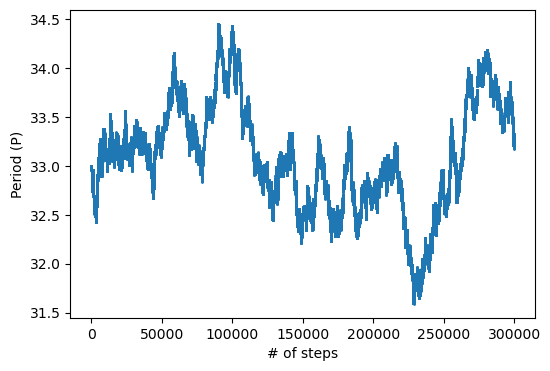

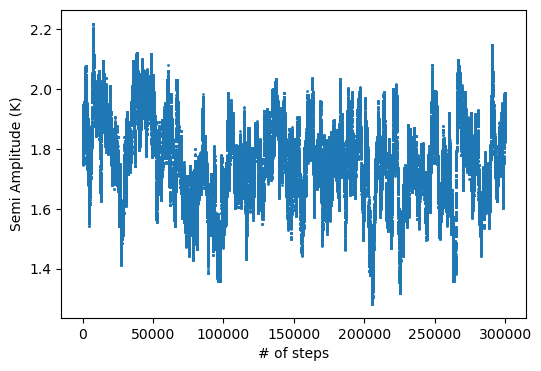

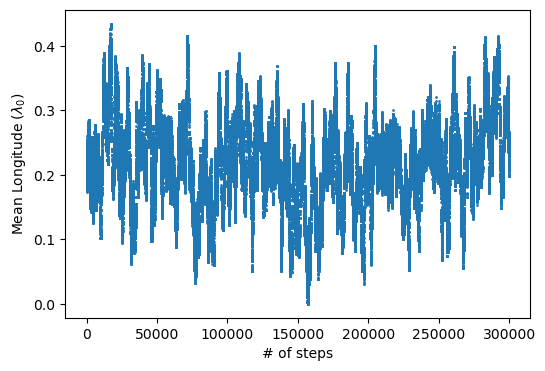

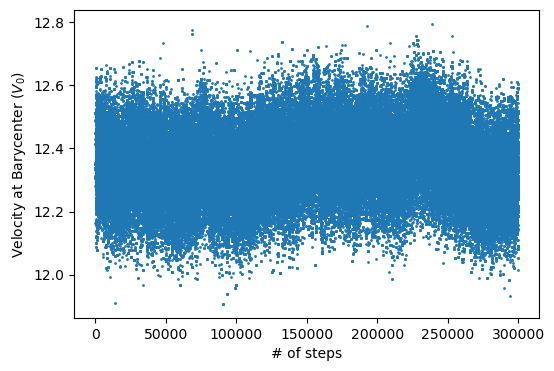

In [21]:
x = np.linspace(0, len(chain), len(chain))
print(chain[:, 0])
print(acc)

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,0], s=1)
plt.xlabel('# of steps')
plt.ylabel(r'Period (P)')

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,1], s=1)
plt.xlabel('# of steps')
plt.ylabel(r'Semi Amplitude (K)')

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,2], s=1)
plt.xlabel('# of steps')
plt.ylabel(r'Mean Longitude $(\lambda_0)$')

plt.subplots(figsize=(6, 4))
plt.scatter(x, chain[:,3], s=1)
plt.xlabel('# of steps')
plt.ylabel(r'Velocity at Barycenter $(V_0)$')

## Convergence Test (Gelman-Rubin)

1) Run M different chains, with different starting points

2) Discard burnins

3) Calculate for each parameter the posterior mean

4) Calculate the intra-chain variance

5) Calculate the mean of all chains

6) Compute how the individual means vary around the joint mean

7) Compute the average variances (W) of the chains

8) Define V; under convergence, this is an unbiased estimator of the true variance. But if the chains have converged, then W is also an unbiased estimate of the true variance

9) Test wether R=sqrt(V/W)=1. If not, then convergence has not been reached

Source: https://www.imperial.ac.uk/media/imperial-college/research-centres-and-groups/astrophysics/public/icic/data-analysis-workshop/2018/Convergence-Tests.pdf

In [55]:
print(33)
print(K)
print(lamb0)
print(V0)

33
1.778541775288376
0.22646629702485993
12.351074172134894


In [57]:


sigmas = [0.01, 0.01, 0.005, 0.5]

Chains = []
Acc = []
for ii in range(100):
    # Generate new random starting values for each iteration
    periods = random.uniform(33 * 0.8, 33 * 1.2)    
    amplitudes = random.uniform(K * 0.7, K * 1.3)   
    phases = random.uniform(lamb0 - 0.01, lamb0 + 0.5) 
    velos = random.uniform(V0 - 5, V0 + 5)            
    theta_starts = [periods, amplitudes, phases, velos]
    
    # Pass the entire theta_starts list, not an indexed element
    chain, acc = mh_sampler(theta_starts, sigmas, 30000, time1, rv1, sig1)
    Acc.append(acc)
    Chains.append(chain)
    
Cut_chains = []
for ii in range(len(Chains)):
    nsamples = Chains[ii].shape[0]

    # Finds indice at a quarter of data and takes everything after that
    burnin = nsamples // 4
    samples = Chains[ii][burnin:, :]
    
    Cut_chains.append(samples) 

KeyboardInterrupt: 

In [54]:
individual_P_means = []
individual_K_means = []
individual_lamb_means = []
individual_V_means = []

intra_chain_vars_P = []
intra_chain_vars_K = []
intra_chain_vars_lamb = []
intra_chain_vars_V = []

M = len(Cut_chains)  # Number of chains
N = len(Cut_chains[0])  # Length of each chain

for ii in range(len(Cut_chains)):
    post_mean = np.mean(Cut_chains[ii], axis=0)
    P_mean, K_mean, lam0_mean, V0_mean = post_mean
    individual_P_means.append(P_mean)
    individual_K_means.append(K_mean)
    individual_lamb_means.append(lam0_mean)
    individual_V_means.append(V0_mean)
    
    intra_chain_vars_P.append(np.var(Cut_chains[ii][:, 0], ddof=1))
    intra_chain_vars_K.append(np.var(Cut_chains[ii][:, 1], ddof=1))
    intra_chain_vars_lamb.append(np.var(Cut_chains[ii][:, 2], ddof=1))
    intra_chain_vars_V.append(np.var(Cut_chains[ii][:, 3], ddof=1))

P_mean = np.mean(individual_P_means)
K_mean = np.mean(individual_K_means)
lamb_mean = np.mean(individual_lamb_means)
V_mean = np.mean(individual_V_means)




B_P = (N / (M - 1)) * np.sum([(theta_m - P_mean)**2 for theta_m in individual_P_means])
B_K = (N / (M - 1)) * np.sum([(theta_m - K_mean)**2 for theta_m in individual_K_means])
B_lamb = (N / (M - 1)) * np.sum([(theta_m - lamb_mean)**2 for theta_m in individual_lamb_means])
B_V = (N / (M - 1)) * np.sum([(theta_m - V_mean)**2 for theta_m in individual_V_means])

W_P = np.mean(intra_chain_vars_P)
W_K = np.mean(intra_chain_vars_K)
W_lamb = np.mean(intra_chain_vars_lamb)
W_V = np.mean(intra_chain_vars_V)

V_hat_P = ((N - 1) / N) * W_P + ((M + 1) / (M * N)) * B_P
V_hat_K = ((N - 1) / N) * W_K + ((M + 1) / (M * N)) * B_K
V_hat_lamb = ((N - 1) / N) * W_lamb + ((M + 1) / (M * N)) * B_lamb
V_hat_V = ((N - 1) / N) * W_V + ((M + 1) / (M * N)) * B_V

# Gelman-Rubin statistic: R̂ = √(V̂/W)
R_hat_P = np.sqrt(V_hat_P / W_P)
R_hat_K = np.sqrt(V_hat_K / W_K)
R_hat_lamb = np.sqrt(V_hat_lamb / W_lamb)
R_hat_V = np.sqrt(V_hat_V / W_V)

print(f"Gelman-Rubin R̂ statistics:")
print(f"P: {R_hat_P:.4f}")
print(f"K: {R_hat_K:.4f}")
print(f"λ: {R_hat_lamb:.4f}")
print(f"V: {R_hat_V:.4f}")

Gelman-Rubin R̂ statistics:
P: 13.9511
K: 5.4051
λ: 17.0620
V: 1.1807


### In order to further explore the posterior distributions we can make a corner plot of the samples for each parameter

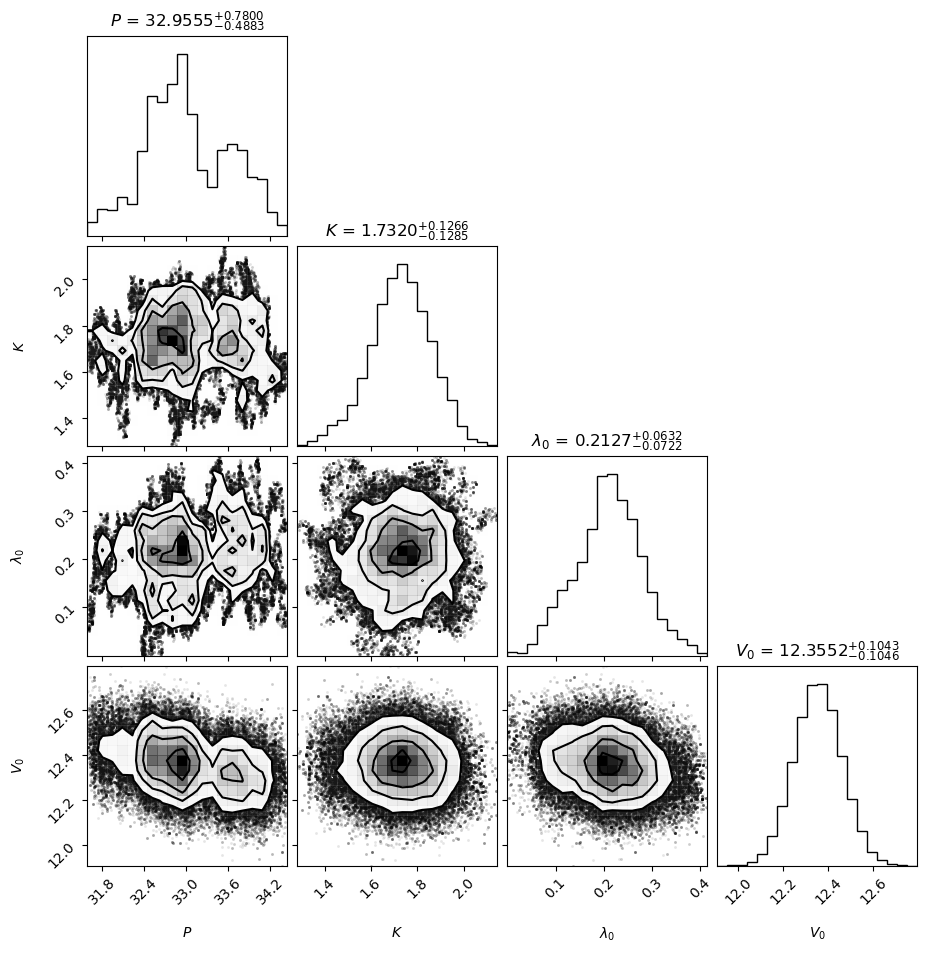

Posterior means:
P = 33.028952
K = 1.728605
λ0 = 0.211053
V0 = 12.355754


Posterior medians:
P = 32.955466
K = 1.731958
λ0 = 0.212676
V0 = 12.355171


In [22]:
nsamples = chain.shape[0]

# Finds indice at a quarter of data and takes everything after that
burnin = nsamples // 4
samples = chain[burnin:, :] 

labels = [r"$P$", r"$K$", r"$\lambda_0$", r"$V_0$"]
fig = corner.corner(samples, labels=labels, show_titles=True, title_fmt=".4f")
plt.show() 

# Calculate posterior means and medians
post_mean   = np.mean(samples, axis=0)
post_median = np.median(samples, axis=0)

P_mean, K_mean, lam0_mean, V0_mean = post_mean
P_med, K_med, lam0_med, V0_med = post_median

# Print posterior means and medians
print("Posterior means:")
print(f"P = {P_mean:.6f}")
print(f"K = {K_mean:.6f}")
print(f"λ0 = {lam0_mean:.6f}")
print(f"V0 = {V0_mean:.6f}")
print('\n')
print("Posterior medians:")
print(f"P = {P_med:.6f}")
print(f"K = {K_med:.6f}")
print(f"λ0 = {lam0_med:.6f}")
print(f"V0 = {V0_med:.6f}")


### To find the minimum mass (msini) we can start by looking at the Semi-Amplitude

### $K=\frac{m}{M+m}\frac{2\pi a \sin i}{P}\cos(\frac{2\pi}{P}+\lambda_0)$

### Using the assumption that M>>m, that equation simplifies to:

### $K=\frac{m}{M}\frac{2\pi a \sin i}{P}\cos(\frac{2\pi}{P}+\lambda_0)$

### We can then reorder this to isolate the minimum mass to be:

### $m\sin i=K\frac{MP}{2\pi a}$ and using Keplers third law: $P^2=\frac{4\pi^2}{GM}a^3$

### $\therefore a=(\frac{P^2GM}{4\pi^2})^\frac{1}{3}$ which we can sub back into our min mass formula yielding

### $m\sin i=K(\frac{P}{2\pi G})^\frac{1}{3}\cdot M^\frac{2}{3}$

### We can now use this formula to calculate the minimum mass given all our samples (minus the burn in)



In [15]:
def min_mass(P, K, M):
    G = 6.67430e-11 
    return K * (P / (2 * np.pi * G))**(1/3) * M**(2/3)

nsamples = chain.shape[0]


# Finds indice at a quarter of data and takes everything after that
burnin = nsamples // 4
samples = chain[burnin:, :] 

minimum_masses = []
for ii in range(len(samples)):
    M = 1.98847e30 # 1 Solar Mass
    P = samples[:, 0][ii] * 86400.0 # converts to seconds
    minimum_masses.append(min_mass(P, samples[:, 1][ii], M))
    
minimum_masses = np.asarray(minimum_masses)
M_earth  = 5.972e+24 
m = minimum_masses / M_earth

minimum mass mean = 9.547271900696371 M_earth
minimum mass median = 9.677470402540001 M_earth


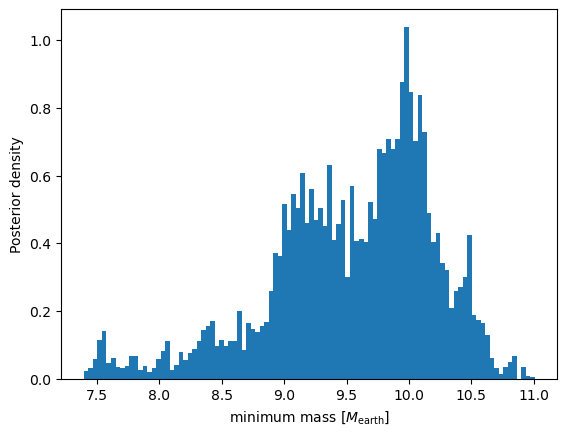

In [16]:
min_mass_mean = np.mean(m)
min_mass_median = np.median(m)

print(f"minimum mass mean = {min_mass_mean} M_earth")
print(f"minimum mass median = {min_mass_median} M_earth")

# --- Histogram of m sin i ---
plt.hist(m, bins=100, density=True)
plt.xlabel(r"minimum mass $[M_{\rm earth}]$")
plt.ylabel("Posterior density")
plt.show()

In [17]:
alpha = 0.95
m = np.array(m)
sorted_m = np.sort(m)
n = len(sorted_m)


k = int(np.floor(alpha * n))


interval_widths = sorted_m[k:] - sorted_m[:n - k]

# index of the smallest-width interval
imin = np.argmin(interval_widths)

m_hpd_low  = sorted_m[imin]
m_hpd_high = sorted_m[imin + k]

print(f"Smallest 95% credible interval (HPD): [{m_hpd_low:.4f}, {m_hpd_high:.4f}]")

Smallest 95% credible interval (HPD): [8.1503, 10.6943]


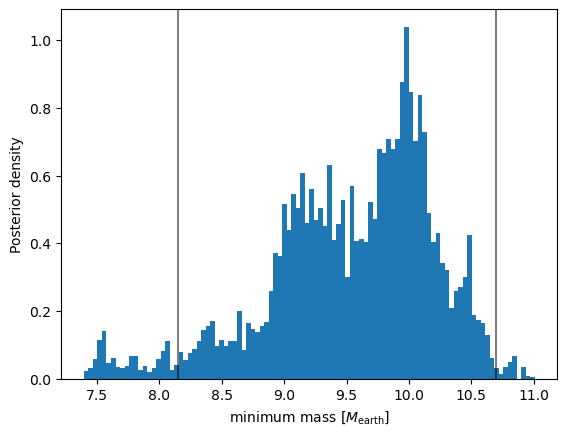

In [18]:
plt.hist(m, bins=100, density=True)
plt.xlabel(r"minimum mass $[M_{\rm earth}]$")
plt.ylabel("Posterior density")
plt.axvline(m_hpd_low, color='black', alpha=.5)
plt.axvline(m_hpd_high, color='black', alpha=.5) 
plt.show()

Central 95% credible interval (equal tails): [7.8231, 10.5589]


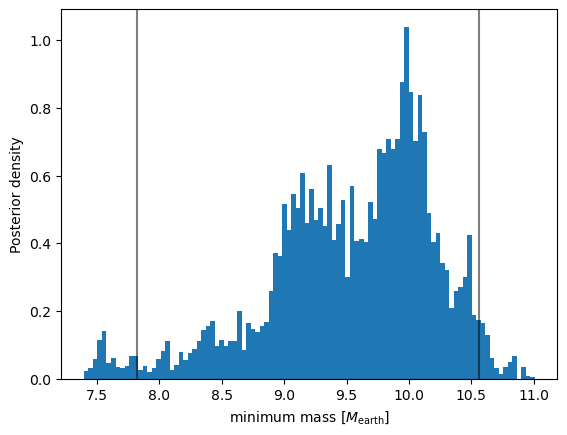

In [19]:
m_low = np.percentile(m, 2.5)
m_high = np.percentile(m, 97.5)
print(f"Central 95% credible interval (equal tails): [{m_low:.4f}, {m_high:.4f}]")

plt.hist(m, bins=100, density=True)
plt.xlabel(r"minimum mass $[M_{\rm earth}]$")
plt.ylabel("Posterior density")
plt.axvline(m_low, color='black', alpha=.5)
plt.axvline(m_high, color='black', alpha=.5) 
plt.show()